# Statistical analysis

In [6]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

datafilename = "data_processed.csv"
d = pd.read_csv(datafilename)
#d = d[-72:] # use just the data for the  last participant

print("Loading", len(d), "lines.")

# functions to calculate AUC and plot ROC

def cummulative(x):
    return [sum(x[0:i+1]) for i in range(len(x))]

def get_auc(x, y):
    # make cummulative
    x, y = cummulative(x), cummulative(y)
    # normalize
    x = [xi/max(x) for xi in x]
    y = [yi/max(y) for yi in y]
    auc = 0
    x1, y1 = 0, 0
    for x2, y2 in zip(x, y):
        auc += (x2 - x1) * (y1 + y2) / 2
        x1, y1 = x2, y2
    return auc

def plot_roc(x, y):
    x, y = cummulative(x), cummulative(y)
    plt.plot((min(x), max(x)), (min(y), max(y)), color='red', linewidth=1, linestyle='--')
    for i in range(len(x)-1):
        plt.plot((x[i], x[i+1]), (y[i], y[i+1]), color='black', linewidth=1)
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker='o', s=30, color='black')
    #plt.xlim(0.0, 1.0)
    #plt.ylim(0.0, 1.0)
    plt.show()

Loading 9936 lines.


## Participants

In [13]:
TPP = 72  # there are 72 trials per participant
TPT = 36  # there are 36 trials per test
TPL = 20  # there are 20 trials per lexical test

for sid in [1, 2]:
    dt = d[d["Study ID"] == sid]
    if not dt.empty:
        print()
        print()
        print("## Counts for study ID:", sid)
        print()
        print("Number of participants:")
        print(len(dt) / TPP) 
        print()
        print("Fluent vs. non-native:")
        print(dt["Fluent"].value_counts() / TPP)
        print()
        print("Different kinds of designers:")
        print(dt["Designer"].value_counts() / TPP)
        print()
        print("Which font was first:")
        print(dt[(dt["Test ID"] == 1) & (dt["Test type"] == "lexical")]["Font"].value_counts() / TPL)
        print()
        print("JoM for categories of designers:")
        display(dt.groupby("Designer")["JoM"].mean())
        print()
        print("JoL for categories of designers:")
        display(dt.groupby("Designer")["JoL"].value_counts() / TPT)





## Counts for study ID: 1

Number of participants:
86.0

Fluent vs. non-native:
True     82.0
False     4.0
Name: Fluent, dtype: float64

Different kinds of designers:
Non-designer        42.0
Letter designer     24.0
Graphic designer    11.0
Typographer          5.0
Other designer       4.0
Name: Designer, dtype: float64

Which font was first:
sansforgetica    47.0
arial            39.0
Name: Font, dtype: float64

JoM for categories of designers:


Designer
Graphic designer    57.590909
Letter designer     55.187500
Non-designer        55.261905
Other designer      50.625000
Typographer         61.000000
Name: JoM, dtype: float64


JoL for categories of designers:


Designer          JoL                   
Graphic designer  very easy to read         10.0
                  ok                         6.0
                  easy to read               3.0
                  very difficult to read     2.0
                  difficult to read          1.0
Letter designer   very easy to read         14.0
                  difficult to read         12.0
                  ok                        11.0
                  easy to read               8.0
                  very difficult to read     3.0
Non-designer      very easy to read         37.0
                  ok                        22.0
                  difficult to read         12.0
                  easy to read              11.0
                  very difficult to read     2.0
Other designer    ok                         4.0
                  very easy to read          3.0
                  difficult to read          1.0
Typographer       very easy to read          4.0
                  difficult 



## Counts for study ID: 2

Number of participants:
52.0

Fluent vs. non-native:
True    52.0
Name: Fluent, dtype: float64

Different kinds of designers:
Non-designer        38.0
Letter designer      8.0
Graphic designer     3.0
Other designer       2.0
Typographer          1.0
Name: Designer, dtype: float64

Which font was first:
sansforgetica    30.0
arial            22.0
Name: Font, dtype: float64

JoM for categories of designers:


Designer
Graphic designer    64.166667
Letter designer     60.312500
Non-designer        55.315789
Other designer      54.250000
Typographer         67.000000
Name: JoM, dtype: float64


JoL for categories of designers:


Designer          JoL                   
Graphic designer  very easy to read          3.0
                  difficult to read          2.0
                  ok                         1.0
Letter designer   difficult to read          6.0
                  easy to read               5.0
                  very easy to read          3.0
                  ok                         1.0
                  very difficult to read     1.0
Non-designer      very easy to read         33.0
                  ok                        17.0
                  difficult to read         10.0
                  easy to read              10.0
                  very difficult to read     6.0
Other designer    difficult to read          2.0
                  easy to read               1.0
                  very easy to read          1.0
Typographer       ok                         1.0
                  very easy to read          1.0
Name: JoL, dtype: float64

## Calculating AUC and RT

In [14]:
# for every (study, test, participant) combination
# calculate AUC for their responses to all the relevant trials (i.e. 36 trials in a test)
# and the averge response time

result_columns = ["Study ID", "Participant ID", "Test ID", "Test type",
                  "Native", "Designer", "Font", "Correct", "Response time",
                  "Response time (word)", "Response time (non-word)",
                  "AUC", "AUC (word)", "AUC (non-word)",
                  "JoL", "JoM", "Date"]
agg_columns = {k:"first" for k in set(d.columns).intersection(result_columns)}
agg_columns["Correct"] = "mean"
agg_columns["Response time"] = "mean"
results = d.groupby(["Study ID", "Participant ID", "Test ID", "Test type"]).agg(agg_columns)
results = pd.DataFrame(results, columns=result_columns)
results.set_index(["Study ID", "Participant ID", "Test ID", "Test type"], inplace=True)

# prepare indexes for temporary data frames
ix = {}
test_ids = set(d["Test ID"].unique())
category_used = "Category"
categories = ["word", "non-word"]
responses = ["Sure word", "Probably word", "Probably non-word", "Sure non-word"]
ix["lexical"] = (category_used, pd.MultiIndex.from_product([categories, responses], names=[category_used, "Response"]))
category_used = "Seen"
categories = ["seen", "not seen"]
responses = ["Sure seen", "Probably seen", "Probably not seen", "Sure not seen"]
ix["recognition"] = (category_used, pd.MultiIndex.from_product([categories, responses], names=[category_used, "Response"]))

for sid in d["Study ID"].unique():
    for pid in d[d["Study ID"] == sid]["Participant ID"].unique():
        for tid in test_ids:
            dt = d[(d["Study ID"] == sid) & (d["Participant ID"] == pid) & (d["Test ID"] == tid)]
            for ttype in dt["Test type"].unique():
                category_used, index = ix[ttype]
                # ensure the order in the index is always the same
                dg = pd.DataFrame(index=index)
                dg["Frequencies"] = dt[dt["Test type"] == ttype].groupby([category_used])["Response"].value_counts()
                dg = dg.fillna(0)
                # frequencies for word/seen -> y coordinate
                # frequencies for non-word/not seen -> x coordinate
                freqs = dg["Frequencies"].tolist()
                auc = get_auc(freqs[4:], freqs[:4])
                results.loc[(sid, pid, tid, ttype), "AUC"] = auc
                rt = dt[dt["Test type"] == ttype]["Response time"].mean()
                results.loc[(sid, pid, tid, ttype), "Response time"] = rt
                for cat in ["word", "non-word"]:
                    if ttype == "recognition":
                        dg["Frequencies"] = dt[(dt["Test type"] == ttype) & (dt["Category"] == cat)].groupby([category_used])["Response"].value_counts()
                        dg = dg.fillna(0)
                        freqs = dg["Frequencies"].tolist()
                        auc = get_auc(freqs[4:], freqs[:4])
                        results.loc[(sid, pid, tid, ttype), "AUC (%s)" % cat] = auc
                    rt = dt[(dt["Test type"] == ttype) & (dt["Category"] == cat)]["Response time"].mean()
                    results.loc[(sid, pid, tid, ttype), "Response time (%s)" % cat] = rt
            
display(results[-4:])
results.to_csv(datafilename.replace("_processed.csv", "_stats.csv"))

Native      Designer  \
Study ID Participant ID Test ID Test type                           
2.0      3672.0         1       lexical         NaN  Non-designer   
                                recognition     NaN  Non-designer   
                        2       lexical         NaN  Non-designer   
                                recognition     NaN  Non-designer   

                                                      Font  Correct  \
Study ID Participant ID Test ID Test type                             
2.0      3672.0         1       lexical              arial   0.9500   
                                recognition  sansforgetica   0.7500   
                        2       lexical      sansforgetica   1.0000   
                                recognition          arial   0.5625   

                                             Response time  \
Study ID Participant ID Test ID Test type                    
2.0      3672.0         1       lexical           2817.600   
                                recognition       3352.125   
                        2       lexical           2655.300   
                                recognition       2763.000   

                                             Response time (word)  \
Study ID Participant ID Test ID Test type                           
2.0      3672.0         1       lexical                  2083.300   
                                recognition              3185.250   
                        2       lexical                  1993.700   
                                recognition              2567.125   

                                             Response time (non-word)  \
Study ID Participant ID Test ID Test type                               
2.0      3672.0         1       lexical                      3551.900   
                                recognition                  3519.000   
                        2       lexical                      3316.900   
                                recognition                  2958.875   

                                                  AUC  AUC (word)  \
Study ID Participant ID Test ID Test type                           
2.0      3672.0         1       lexical      1.000000         NaN   
                                recognition  0.812500     0.93750   
                        2       lexical      1.000000         NaN   
                                recognition  0.648438     0.65625   

                                             AUC (non-word)  \
Study ID Participant ID Test ID Test type                     
2.0      3672.0         1       lexical                 NaN   
                                recognition         0.75000   
                        2       lexical                 NaN   
                                recognition         0.71875   

                                                           JoL  JoM  \
Study ID Participant ID Test ID Test type                             
2.0      3672.0         1       lexical           easy to read   50   
                                recognition       easy to read   50   
                        2       lexical      difficult to read   46   
                                recognition  difficult to read   46   

                                                         Date  
Study ID Participant ID Test ID Test type                      
2.0      3672.0         1       lexical      12-04-2019 09:34  
                                recognition  12-04-2019 09:34  
                        2       lexical      12-04-2019 09:34  
                                recognition  12-04-2019 09:34

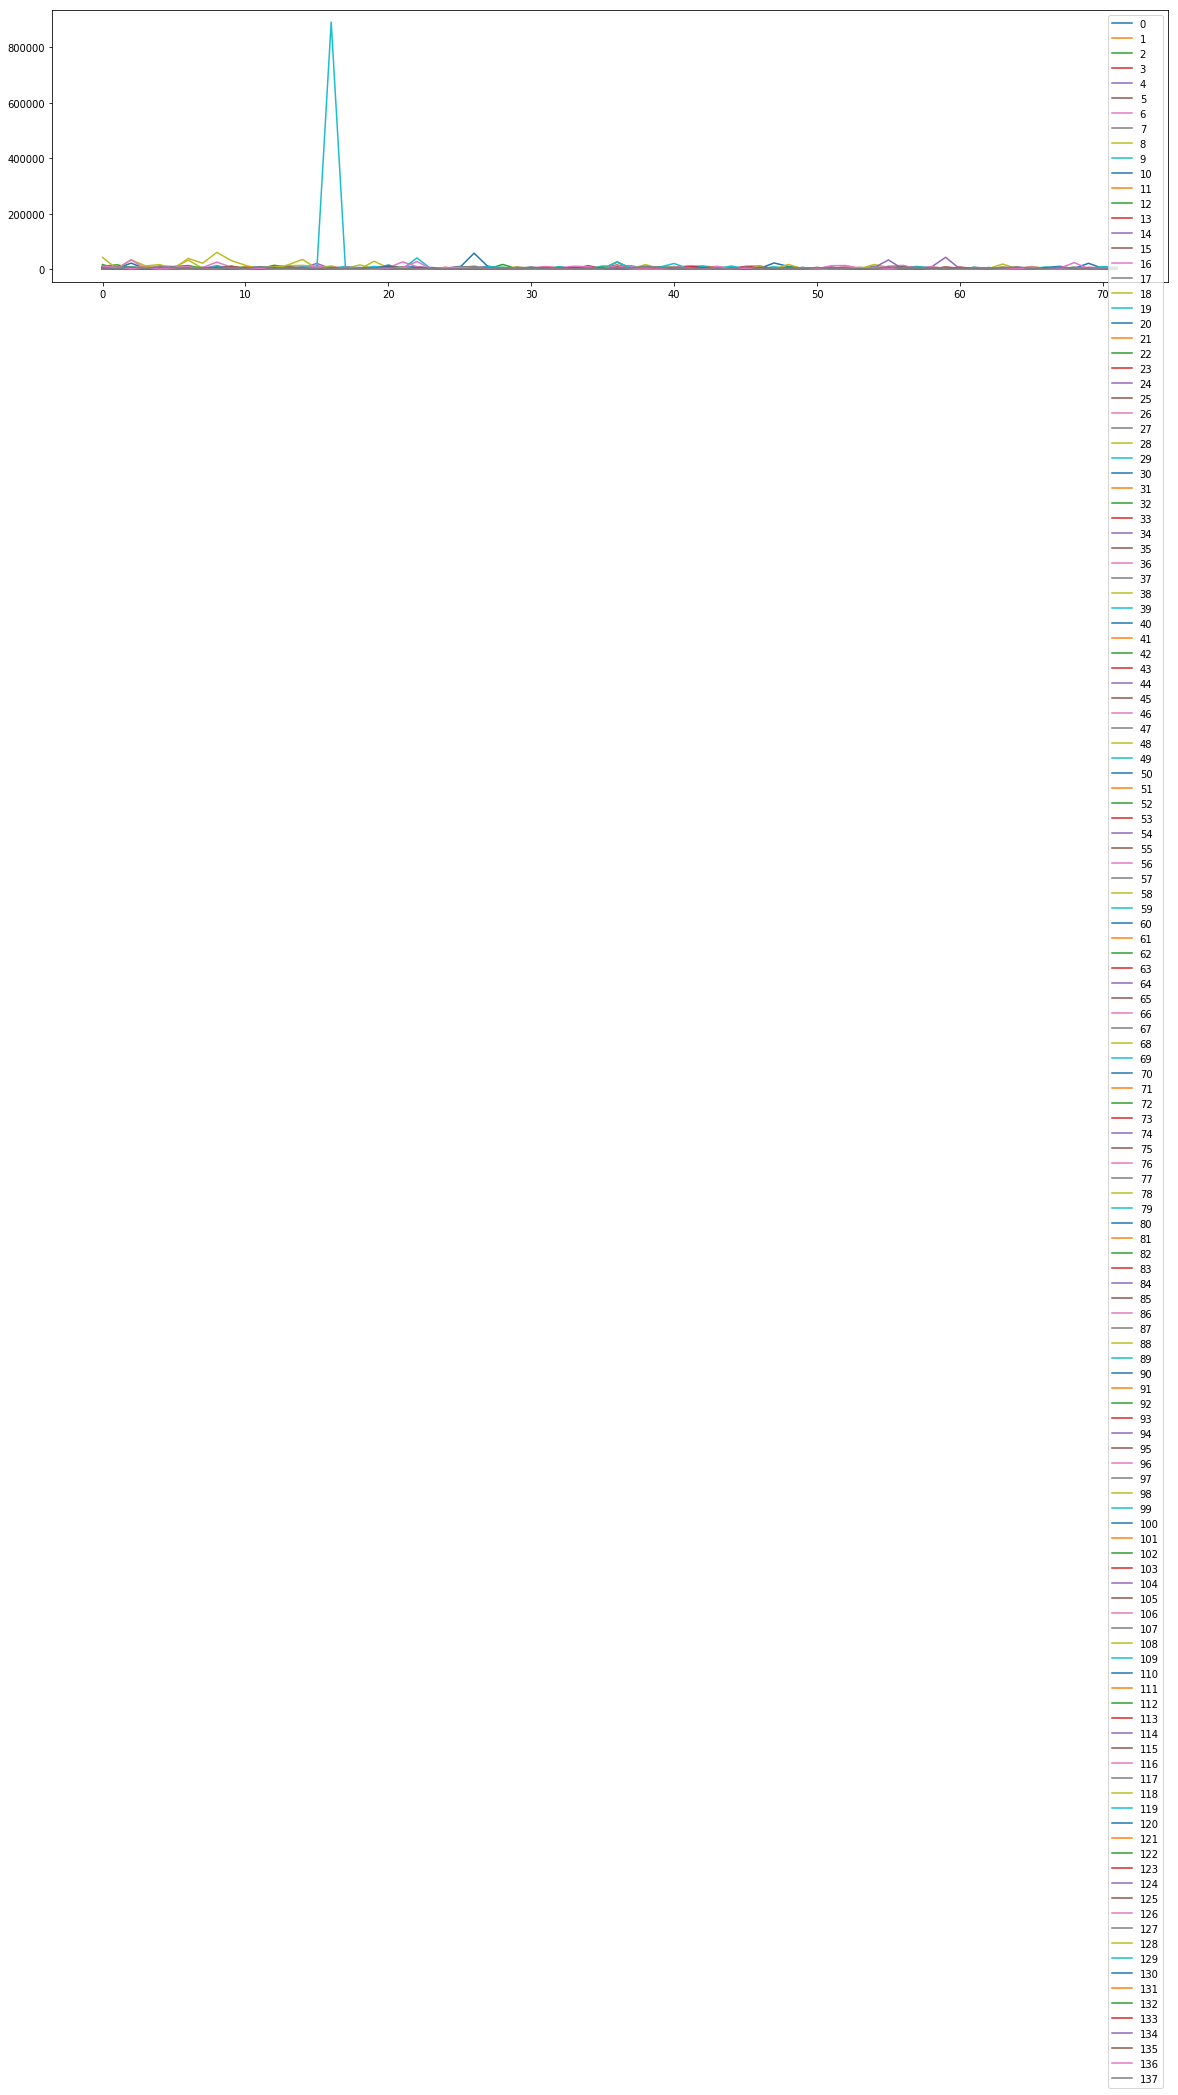

In [15]:
times = pd.DataFrame(d, columns=["Study ID", "Participant ID", "Test ID", "Test type", "Response time"])
times.set_index(["Study ID", "Participant ID", "Test ID", "Test type"], inplace=True)
times = pd.DataFrame(times.values.reshape((-1,72)))
#display(times)
times.T.plot(figsize=(20,5))

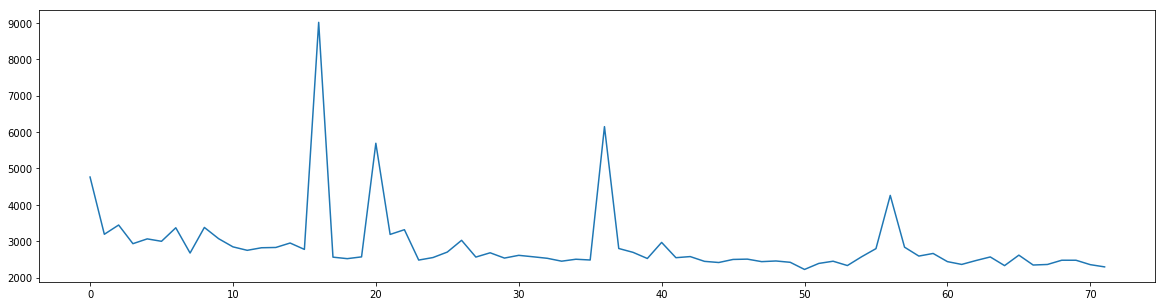

In [16]:
times.mean().plot(figsize=(20,5))